In [ ]:
# IRS ML Benchmark V0.1
# Oxford Flowers 102 with EffecientNet-B3

In [1]:
import os
import sys
import time
import tensorflow as tf
from tensorflow.keras import models, Model, mixed_precision
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')
enable_XLA = False  # make sure XLA is disabled to ensure fair comparison of pure GPU performance - see more details below

if enable_XLA:
    # The 2 lines below enables XLA. This enables faster training in all cases BUT the time taken to initiate training will be slower and is largely CPU-bounded, thus disable it for strict benchmarking of GPU perf only, and enable it for your own experimentation
    os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
    tf.config.optimizer.set_jit(True)
else:
    os.environ['TF_XLA_FLAGS'] = ''
    tf.config.optimizer.set_jit(False)

print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6
Running on Python 3.9.9 (tags/v3.9.9:ccb0e6a, Nov 15 2021, 18:08:50) [MSC v.1929 64 bit (AMD64)], Tensorflow 2.7.0.


In [2]:
# Hyperparameters

lr = 1e-3  # Adam default is 1e-3
batch_size = 64
epoch = 10
img_height = 224
img_width = 224

In [3]:
# Dataset loading (Oxford Flower 102)

labels = 'inferred'
label_mode = 'categorical'  # sparse one hot encoding
color_mode = 'rgb'
shuffle = True
seed = 69
test_split = 0.2  # split into train and test (NOT val), 0-1
AUTOTUNE = tf.data.AUTOTUNE

print('Training data:')
train = tf.keras.preprocessing.image_dataset_from_directory('train', labels=labels, label_mode=label_mode,
color_mode=color_mode, shuffle=shuffle, seed=seed, image_size=(img_height, img_width), batch_size=batch_size)
train_class_names = train.class_names

print('\nValidation data:')
val = tf.keras.preprocessing.image_dataset_from_directory('val', labels=labels, label_mode=label_mode,
color_mode=color_mode, shuffle=shuffle, seed=seed, image_size=(img_height, img_width), batch_size=batch_size)

print('\nTesting data:')
test = tf.keras.preprocessing.image_dataset_from_directory('test', labels=labels, label_mode=label_mode,
color_mode=color_mode, shuffle=shuffle, seed=seed, image_size=(img_height, img_width), batch_size=batch_size)

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

Training data:
Found 5248 files belonging to 102 classes.

Validation data:
Found 1320 files belonging to 102 classes.

Testing data:
Found 1621 files belonging to 102 classes.


In [4]:
# model

xInput = Input((img_height, img_width, 3), dtype=tf.float16)
efficient_net = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet')
x = efficient_net(xInput)
x = Flatten()(x)
x = Dense(256)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
xOutput = Dense(len(train_class_names), dtype=tf.float32)(x)  # no activation as loss using logit=True, need use float32 here to ensure model accuracy
model = tf.keras.models.Model(xInput, xOutput)

43950080/43941136 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 flatten (Flatten)           (None, 75264)             0         
                                                                 
 dense (Dense)               (None, 256)               19267840  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                             

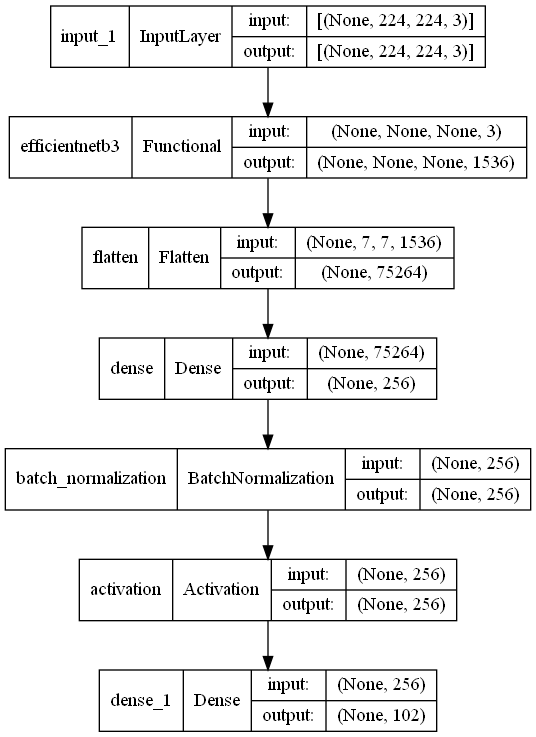

In [5]:
# compile model

opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
metrics = ['accuracy']
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1,
#                                      mode='auto', baseline=None, restore_best_weights=True),
#     tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
#     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1)
# ]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [6]:
# Training
start_time = time.time()
history = model.fit(train, epochs=epoch, validation_data=val, batch_size=batch_size, verbose=1)
end_time = time.time()
print(f'Training time used: {end_time - start_time} seconds')

Epoch 1/10
82/82 [==============================] - 30s 189ms/step - loss: 1.8917 - accuracy: 0.7348 - val_loss: 1.5961 - val_accuracy: 0.7924

In [7]:
# Evaluate
start_time = time.time()
model.evaluate(test, batch_size=batch_size)
end_time = time.time()
print(f'Evaluation time used: {end_time - start_time} seconds')  # Reminder: model accuracy in this benchmark has no meaning because no callbacks are used and it is very likely to overfit.

26/26 [==============================] - 1s 43ms/step - loss: 0.9021 - accuracy: 0.9815